In [1]:
import pyspark
import re
import pyspark.sql
from pyspark.sql import *
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
import os.path
from pyspark.sql.functions import desc

import findspark
findspark.init()

from pyspark.sql import dataframe
from pyspark.sql import functions as F

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

%matplotlib inline

# import get_ref_info.py
import os
import sys
my_fun = '../src/'
if my_fun not in sys.path:
    sys.path.append(my_fun)
    
from get_ref_info import *

from operator import add
from urllib.parse import urlparse
import seaborn as sns

---

# Loading the data

In [2]:
# Loading the data
DATA_DIR = '../' 
WIKIPEDIA_CONFLICTS_PARQUET = DATA_DIR + 'selectedAllConflict.parquet'

# loading the saved parquet files
wikipedia = spark.read.parquet(WIKIPEDIA_CONFLICTS_PARQUET)
wikipedia.show(10)

+------+---+------------+--------------------+--------------------+-----------------+---------------+
|    id| ns|restrictions|            revision|               title|       categories|good_categories|
+------+---+------------+--------------------+--------------------+-----------------+---------------+
|655845|  0|        null|[, [,, 5175837,, ...|Battle of Athens ...|military conflict|           true|
|656035|  0|        null|[[link,], [,, 268...|  Battle of Calabria|military conflict|           true|
|656087|  0|        null|[, [,,, 96.77.37....|   Italo-Turkish War|military conflict|           true|
|656173|  0|        null|[[Formatting.,], ...|Third Anglo-Afgha...|military conflict|           true|
|656175|  0|        null|[[/* 1879 */The B...|Second Anglo-Afgh...|military conflict|           true|
|656473|  0|        null|[[Moved images.,]...|   Illinois campaign|military conflict|           true|
|659156|  0|        null|[, [,, 29980587,,...|Battle of Kock (1...|military confli

---

## [POPULARITY METRIC 1] 

### Get number of references per page

We use our pre-filtered data and we count the number of tag of type ```<ref>```, by parsing all pages to get the number of references. We think that the more *popular* a page is, the more references it will contain.

We want to see:
* how many references a page has
* what does the distribution of the references look like 
* what are the top domains across these articles 
* how many articles have a reference to each domain

The analysis is based on work from *Research:Characterizing Wikipedia Citation Usage*: [MetaPageQueries](https://meta.wikimedia.org/wiki/Research:Characterizing_Wikipedia_Citation_Usage/First_Round_of_Analysis#Dimensions_of_Analysis)

Example of reference format:
```html
<ref>{{cite web| url=http://geonames.nga.mil/ggmagaz/geonames4.asp 
    |title=NGA GeoName Database |publisher=[[National Geospatial Intelligence Agency]] 
    |accessdate=2008-07-05 
    |archiveurl = https://web.archive.org/web/20080608190852/http://geonames.nga.mil/ggmagaz/geonames4.asp 
    <!-- Bot retrieved archive --> |archivedate = 2008-06-08}}</ref>
```

**quantify the number of references per page**
    * using regex expression to find the references in the page
    * counting the number of references

In [3]:
# quantify the number of references per page

# Compile a regular expression pattern into a regular expression object, 
#which can be used for matching using its findall.
just_ref_regex = re.compile(r'<ref[^>]*[^\/]>|<ref[ ]*>')

# find # references <ref> per page 
def get_refs_count(entity, regex_expression=just_ref_regex ):
    # get access to value in text in revision
    text = entity.revision.text._VALUE
    # find references
    refs = just_ref_regex.findall(text)
    return Row(id=entity.id, refs_count=len(refs), categories=entity.categories)

In [4]:
# get the # of references per page
# Creates a DataFrame from an RDD, apply counting function with regex expression
reference_count_page = sqlContext.createDataFrame(wikipedia.rdd.map(get_refs_count))
reference_count_page.sort('refs_count', ascending=False).show(5)
reference_count_page_sql = reference_count_page.registerTempTable('reference_count_page_sql')

+-----------------+--------+----------+
|       categories|      id|refs_count|
+-----------------+--------+----------+
|military conflict|52019122|      1000|
|military conflict|46230181|       818|
|military conflict|42563745|       734|
|military conflict|43243199|       609|
|military conflict|     771|       598|
+-----------------+--------+----------+
only showing top 5 rows



In [5]:
# quantify the # articles with # ref > 0: 
non_zero_ref_query = """
select count(DISTINCT id)
from reference_count_page_sql
where refs_count > 0
"""
non_zero_articles = spark.sql(non_zero_ref_query)

non_zero_articles_pd = non_zero_articles.toPandas().iloc[0,0]
print("Number of articles with #references > 0: " + str(non_zero_articles_pd))

Number of articles with #references > 0: 15986


**Distribution of number of references** We bin the number of references to get the number of pages having at least x #references. This is observed with a histogram plot.

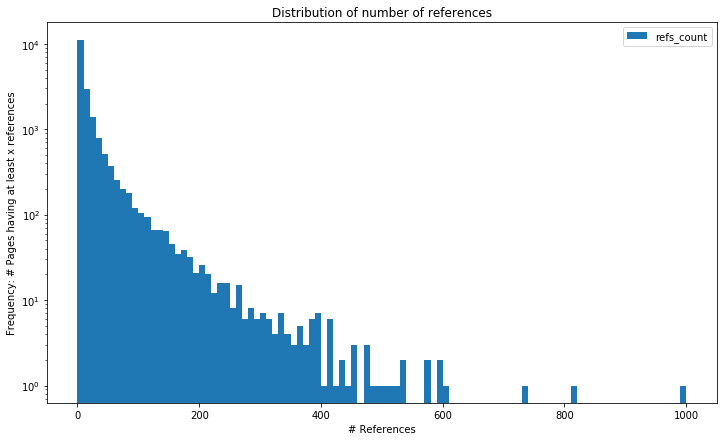

In [6]:
just_refs_count = reference_count_page.select('refs_count').toPandas()
just_refs_count.plot(kind="hist", bins=100, log=True, figsize=(12,7), title="Distribution of number of references")
plt.xlabel('# References')
plt.ylabel('Frequency: # Pages having at least x references')
plt.show()

**Distribution of number of references**: It seems that the distribution may follow a power law. To verify our suspicions, we plot our cumulative distribution in normal axes and in log-log axes. We look at a "cumulative distribution": how many references have at least x pages?

The distribution has a heavy-tailed distribution: they may follow a power law. To recognize if the distirbutions follow a power law, we plot the data in log-log axes. If they follow a power law, reporting mean or variance for a power-law-distributed data is not relevant as these statistics are not robust as they are sensitive to data. Instead, we use robust statistics and report the median and quartiles using boxplots. We compare boxplots with and without outliers.

In [ ]:
reference_count_page_pd = reference_count_page.toPandas().set_index('')

### Get the domains of references

In [25]:
references_rrd = wikipedia.rdd.flatMap(get_ref_info)
references = sqlContext.createDataFrame(references_rrd)
references.show(5)

+-------+-----------------+--------------------+--------------------+
|     id|         template|               title|                 url|
+-------+-----------------+--------------------+--------------------+
|3441926|    cite magazine|A Buried Coup d'É...|https://www.newyo...|
|3441926|        cite news|Race and Politics...|                    |
|3441926|cite encyclopedia|Why Whites Riot: ...|https://libres.un...|
|3441926|         cite web|When Democracy Di...|https://www.nytim...|
|3441926|        cite news|How The Only Coup...|https://www.npr.o...|
+-------+-----------------+--------------------+--------------------+
only showing top 5 rows



**URL parsing** 
Parse a URL into six components, returning a 6-tuple. This corresponds to the general structure of a URL: scheme://netloc/path;parameters?query#fragment. Each tuple item is a string, possibly empty.

In [37]:
def get_domain(row):
    # parse url and return for each row (url, 1) where 1 is the occurence of ref = 1 for that page
    try:
        parsed_uri = urlparse(row['url'])
        return ('{uri.netloc}'.format(uri=parsed_uri), 1)
    except:
        return None

mapped_domains = references.where("length(url)>0").rdd.map(get_domain).filter(lambda row: row is not None)
# for each domain count how many references there are in total to find top domains
domains_count = mapped_domains.reduceByKey(lambda a,b: a+b).filter(lambda r: len(r[0])>0).sortBy(lambda r: -r[1])
domains_count.take(30)

[('www.nytimes.com', 1672),
 ('www.theguardian.com', 1126),
 ('books.google.com', 1120),
 ('www.bbc.co.uk', 879),
 ('www.cnn.com', 818),
 ('www.reuters.com', 751),
 ('www.washingtonpost.com', 722),
 ('www.bbc.com', 666),
 ('news.bbc.co.uk', 646),
 ('www.telegraph.co.uk', 610),
 ('abcnews.go.com', 466),
 ('www.cbsnews.com', 408),
 ('www.independent.co.uk', 404),
 ('edition.cnn.com', 375),
 ('www.aljazeera.com', 372),
 ('www.foxnews.com', 322),
 ('www.latimes.com', 317),
 ('www.dawn.com', 289),
 ('www.usatoday.com', 263),
 ('www.cbc.ca', 256),
 ('cain.ulst.ac.uk', 255),
 ('news.yahoo.com', 252),
 ('www.nbcnews.com', 249),
 ('www.haaretz.com', 237),
 ('www.huffingtonpost.com', 231),
 ('www.wsj.com', 227),
 ('timesofindia.indiatimes.com', 221),
 ('www.jpost.com', 221),
 ('www.nydailynews.com', 209),
 ('tribune.com.pk', 209)]

In [39]:
# count the number of links
number_links = domains_count.map(lambda r: r[1]).reduce(add)
print("Total number of links: {}".format(number_links))

Total number of links: 45034


In [44]:
def percentage(rdd):
    return Row(domain=rdd[0], count=rdd[1], perc=rdd[1]*100/number_links)

domains_distribution = sqlContext.createDataFrame(domains_count.map(percentage)).sort("count", ascending=False)
domains_distribution.show()

+-----+--------------------+------------------+
|count|              domain|              perc|
+-----+--------------------+------------------+
| 1672|     www.nytimes.com|3.7127503663898387|
| 1126| www.theguardian.com| 2.500333081671626|
| 1120|    books.google.com|2.4870098148065907|
|  879|       www.bbc.co.uk|1.9518585957276724|
|  818|         www.cnn.com|1.8164053825998134|
|  751|     www.reuters.com|1.6676289026069193|
|  722|www.washingtonpos...|1.6032331127592485|
|  666|         www.bbc.com| 1.478882622018919|
|  646|      news.bbc.co.uk|1.4344717324688014|
|  610| www.telegraph.co.uk|1.3545321312785894|
|  466|      abcnews.go.com|1.0347737265177421|
|  408|     www.cbsnews.com|0.9059821468224009|
|  404|www.independent.c...|0.8970999689123773|
|  375|     edition.cnn.com|0.8327041790647066|
|  372|   www.aljazeera.com| 0.826042545632189|
|  322|     www.foxnews.com|0.7150153217568948|
|  317|     www.latimes.com|0.7039125993693653|
|  289|        www.dawn.com|0.6417373539

In [52]:
domains_distribution_pd = domains_distribution.toPandas().set_index('domain')

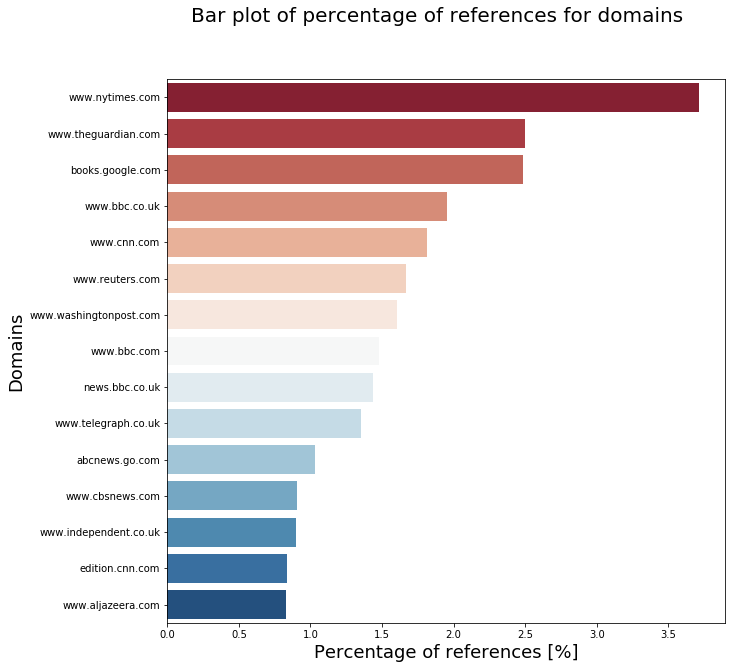

In [61]:
domains_distribution_pd20 = domains_distribution_pd.head(15)
import seaborn as sns
# plot using bar plot
f, ax1 = plt.subplots()
plt.sca(ax1)
sns.barplot(domains_distribution_pd20['perc'], domains_distribution_pd20.index, palette="RdBu", ax=ax1, orient='h')
plt.xlabel('Percentage of references [%]',fontsize=18)
plt.ylabel('Domains',fontsize=18)
f.suptitle('Bar plot of percentage of references for domains', fontsize=20)
f.set_size_inches(10, 10)
plt.show()

--- 

## [POPULARITY METRIC 2] 

### Article length
